# Smooth Overlap of Atomic Positions (SOAP) Descriptors
Prominant 3D representations for molecules include the [Coulomb matrix](./Coulomb-Matrices.ipynb), Smooth Overlap of Atomic Positions (SOAP), Atom-Centered Symmetry Functions (ACSF), the atomic cluster expansion (ACE), atomic features built by the hierarchically interacting particle neural network (HIP-NN), and the N-body iterative contraction of equivariants (NICE).

Here, we demonstrate how to generate SOAP descriptors for molecules.

We will use the same kernel as in the [Fingerprints and SMILES](./1-Fingerprints-and-SMILES.ipynb) notebook, and the QM7 dataset.

## Loading the data
This particular notebook uses `asaplib`, a library containing "Automatic Selection And Prediction" tools for materials and molecules. It provides tools for analyzing and visualizing atomic simulation data.

In [1]:
from asaplib.data import ASAPXYZ

# Import QM7 coordinates using `asaplib`
asapxyz = ASAPXYZ('../data/qm7.xyz', periodic=False)

load xyz file:  ../data/qm7.xyz , a total of  7165 frames , a total of  110650 atoms , with elements:  [1, 6, 7, 8, 16] .


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from asaplib.hypers import universal_soap_hyper

# Get the list of elements (atomic numbers) contained in all frames in the data
global_species = asapxyz.get_global_species()
print(f'List of elements (atomic numbers) found in dataset: {global_species}')

# Automatically generate the hyperparameters of SOAP descriptors for the aforementioned
# list of elements using the 'minimal' settings and output them (dump=True)
universal_soap = 'minimal'
print('Minimal SOAP parameters:')
soap_spec = universal_soap_hyper(global_species, universal_soap, dump=True)

# Modify the hyperparameters as needed
for k in soap_spec.keys():
    soap_spec[k]['rbf'] = 'gto'        # Radial basis function : Gaussian Type Orbitals
    soap_spec[k]['crossover'] = False  # Whether or not to include crossover terms between species

print('Updated SOAP parameters:')
print(soap_spec)

List of elements (atomic numbers) found in dataset: [1, 6, 7, 8, 16]
Minimal SOAP parameters:
{'soap1': {'type': 'SOAP', 'species': [1, 6, 7, 8, 16], 'cutoff': 2.5, 'n': 4, 'l': 3, 'atom_gaussian_width': 0.32}}
Updated SOAP parameters:
{'soap1': {'type': 'SOAP', 'species': [1, 6, 7, 8, 16], 'cutoff': 2.5, 'n': 4, 'l': 3, 'atom_gaussian_width': 0.32, 'rbf': 'gto', 'crossover': False}}


In [3]:
# Specify more parameters
reducer_spec = {'reducer1': {
                          'reducer_type': 'average',  # Options: average, sum, moment_average, moment_sum
                          'element_wise': False}
               }

desc_spec = {'avgsoap': {
                  'atomic_descriptor': soap_spec,
                  'reducer_function': reducer_spec}
            }

In [4]:
# Compute descriptors for the whole structures
asapxyz.compute_global_descriptors(desc_spec_dict=desc_spec,
                                    sbs=[],
                                    keep_atomic=False,  # Set to True to keep the atomic descriptors
                                    tag='qm7',
                                    n_process=4)

Using SOAP Descriptors ...
Using Atomic_2_Global_Average reducer ...


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  88 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 7165 out of 7165 | elapsed:    2.5s finished


## Property prediction using SOAP descriptors
Below we will build and train a model for predicting atomization energy from SOAP descriptors using a multi-layer perceptron (MLP).

In [26]:
# Retrieve the average SOAP descriptors, and set them aside for training
X_train = asapxyz.fetch_computed_descriptors(['avgsoap'])
print(np.shape(X_train))

# Retrieve the target properties
fy = 'atomization_energy'
y_train = asapxyz.get_property(fy)
print(np.shape(y_train))

(7165, 200)
(7165,)


In [27]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

X_train = torch.from_numpy(X_train).float()

# On some computers the explicit cast to .float() is necessary
y_train = torch.from_numpy(y_train).float()

# Define the dataset object using the SOAP descriptors and target value array
dataset = TensorDataset(X_train, y_train)

# Perform a random split
train_ds, val_ds = random_split(dataset, [0.9, 0.1])

In [92]:
import torch.nn as nn

# Define the MLP model architecture, two linear layers with a sigmoid activation after the first
class NNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        return x

Below we will train the MLP for 100 epochs. This can take a couple minutes, depending on your machine.

In [93]:
# Define the input and output tensor size
input_size = X_train.shape[1]
output_size = 1

# Define the training parameters
learning_rate = 0.01
batch_size = 10
hidden_size = 8
num_epochs = 100
log_epochs = 1

# Create an instance of the neural network using the above specifications
nnmodel = NNModel(input_size, hidden_size, output_size)

# Initialize the data loaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size, shuffle=True)

# Initialize the loss function
loss_fn = nn.MSELoss(reduction='mean')

# Initialize the optimizer
optimizer = torch.optim.Adam(nnmodel.parameters(), lr=learning_rate)

# List to keep track of the loss
epoch_losses = []

# Train the model for 100 epochs
for epoch in range(num_epochs):
    epoch_loss = 0
    for x_batch, y_batch in train_loader:
        # 1. Generate predictions
        pred = nnmodel(x_batch)[:, 0]

        # 2. Calculate loss
        loss = loss_fn(pred, y_batch)

        # 3. Compute gradients
        loss.backward()

        # 4. Update parameters using gradients
        optimizer.step()

        # 5. Reset the gradients to zero
        optimizer.zero_grad()

        # 6. Accumulate loss for the epoch using this batch's loss
        epoch_loss += loss.item()

    # Calculate average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    epoch_losses.append(avg_epoch_loss)

    if epoch % log_epochs==0:
        print(f'Epoch {epoch}  Loss {avg_epoch_loss:.4e}')

Epoch 0  Loss 2.3159e+06
Epoch 1  Loss 2.1413e+06
Epoch 2  Loss 1.9804e+06
Epoch 3  Loss 1.8284e+06
Epoch 4  Loss 1.6842e+06
Epoch 5  Loss 1.5472e+06
Epoch 6  Loss 1.4170e+06
Epoch 7  Loss 1.2935e+06
Epoch 8  Loss 1.1763e+06
Epoch 9  Loss 1.0655e+06
Epoch 10  Loss 9.6089e+05
Epoch 11  Loss 8.6245e+05
Epoch 12  Loss 7.7012e+05
Epoch 13  Loss 6.8384e+05
Epoch 14  Loss 6.0356e+05
Epoch 15  Loss 5.2927e+05
Epoch 16  Loss 4.6090e+05
Epoch 17  Loss 3.9831e+05
Epoch 18  Loss 3.4154e+05
Epoch 19  Loss 2.9046e+05
Epoch 20  Loss 2.4494e+05
Epoch 21  Loss 2.0487e+05
Epoch 22  Loss 1.7007e+05
Epoch 23  Loss 1.4045e+05
Epoch 24  Loss 1.1579e+05
Epoch 25  Loss 9.5844e+04
Epoch 26  Loss 8.0268e+04
Epoch 27  Loss 6.4418e+04
Epoch 28  Loss 5.1896e+04
Epoch 29  Loss 4.2769e+04
Epoch 30  Loss 3.5849e+04
Epoch 31  Loss 3.0623e+04
Epoch 32  Loss 2.6776e+04
Epoch 33  Loss 2.3908e+04
Epoch 34  Loss 2.1853e+04
Epoch 35  Loss 2.0328e+04
Epoch 36  Loss 1.9280e+04
Epoch 37  Loss 1.8517e+04
Epoch 38  Loss 1.8001e

Let's visualize the loss curve:

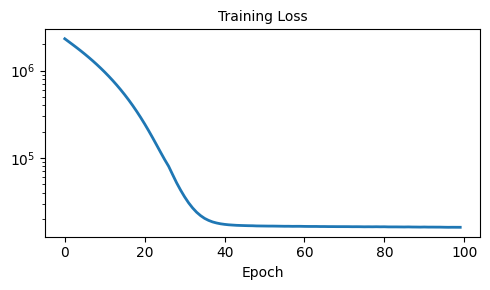

In [95]:
fig = plt.figure(figsize=(5, 3))

ax = fig.add_subplot(1, 1, 1)

# Plot the loss as a function of the number of training epochs
ax.plot(epoch_losses, lw=2)
ax.set_xlabel('Epoch', size=10)
ax.set_title('Training Loss', size=10)
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()

plt.show()

The model should look pretty much converged after about 40 training epochs. 

Let's see how the model predictions compare to the true values for atomization energy after 100 epochs of training with the above set of parameters.

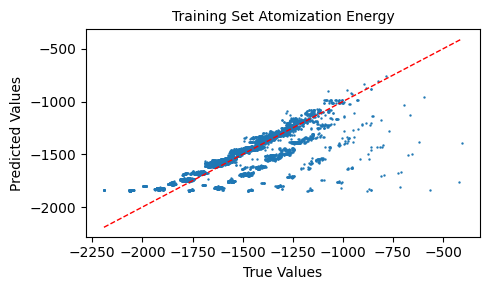

In [98]:
# Make predictions for the training set
predictions = nnmodel(X_train)[:, 0]

# Convert the torch tensors into a datatype that is easy to plot
pred_y = predictions.detach().numpy()  # Detach from the computation graph and convert to np.array()
true_y = y_train.numpy()  # Convert to np.array()

fig = plt.figure(figsize=(5, 3))

ax = fig.add_subplot(1, 1, 1)

# Plot the predictions against the true (reference) values
ax.scatter(true_y, pred_y, s=0.5)
ax.plot()
ax.set_title('Training Set Atomization Energy', size=10)
ax.set_xlabel('True Values', size=10)
ax.set_ylabel('Predicted Values', size=10)
ax.tick_params(axis='both', which='major', labelsize=10)

# Add an equality line in red for reference
min_val = min(min(true_y), min(pred_y))
max_val = max(max(true_y), max(pred_y))
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)

plt.tight_layout()

plt.show()

The model predictions should look pretty good, with most of the predictions falling close to the equality line, and some points where the atomization energy is systematically over-estimated by the model. This generally happens for points with smaller (closer to zero) atomization energies, where we have fewer samples in the training set, but there are also points close to the equality line that are systematically over-estimated by the same amount, even in well-sampled regions. There are also a few points in the dataset with large (more negative) reference values for the atomization energy in the training set, and those values are systematically under-estimated by the model.

If you want to explore more, you can go back and play with the model parameters to see how they impact the model performance.

## Tips💡

### Selecting parameters
As demonstrated in this notebook, SOAP descriptors can effectively represent atomic environments and have numerous applications in materials science and computational chemistry. However, when applying them to new systems, it is crucial to carefully select and tune the parameters, as well as validate the descriptors within those systems, to ensure they capture the necessary chemical information. SOAP descriptors often need recalibration for different molecular systems, and their generalizability should be assessed using a hold-out set. The effectiveness of SOAP descriptors heavily depends on the chosen parameters, such as the cutoff radius and the inclusion of crossover terms. Since there is no one-size-fits-all set of parameters, different settings will yield different SOAP descriptors, necessitating careful optimization for each specific application.